In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap

df_train = pd.read_csv("./preprocessed_heart_train_val.csv")
df_test = pd.read_csv("./preprocessed_heart_test.csv")

df_train

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Female,ChestPainType is _ATA,ChestPainType is _NAP,ChestPainType is _TA,RestingECG is _LVH,RestingECG is _ST,ST_Slope is _Down,ST_Slope is _Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,48.0,138.0,214.0,0.0,108.0,1.0,1.5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,39.0,120.0,339.0,0.0,170.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41.0,120.0,157.0,0.0,182.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
730,57.0,140.0,241.0,0.0,123.0,1.0,0.2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,45.0,110.0,264.0,0.0,132.0,0.0,1.2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
732,68.0,144.0,193.0,1.0,141.0,0.0,3.4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Separate features and target
X_train = df_train.drop(columns=['HeartDisease'])
X_test = df_test.drop(columns=['HeartDisease'])
y_train = df_train['HeartDisease']
y_test = df_test['HeartDisease']

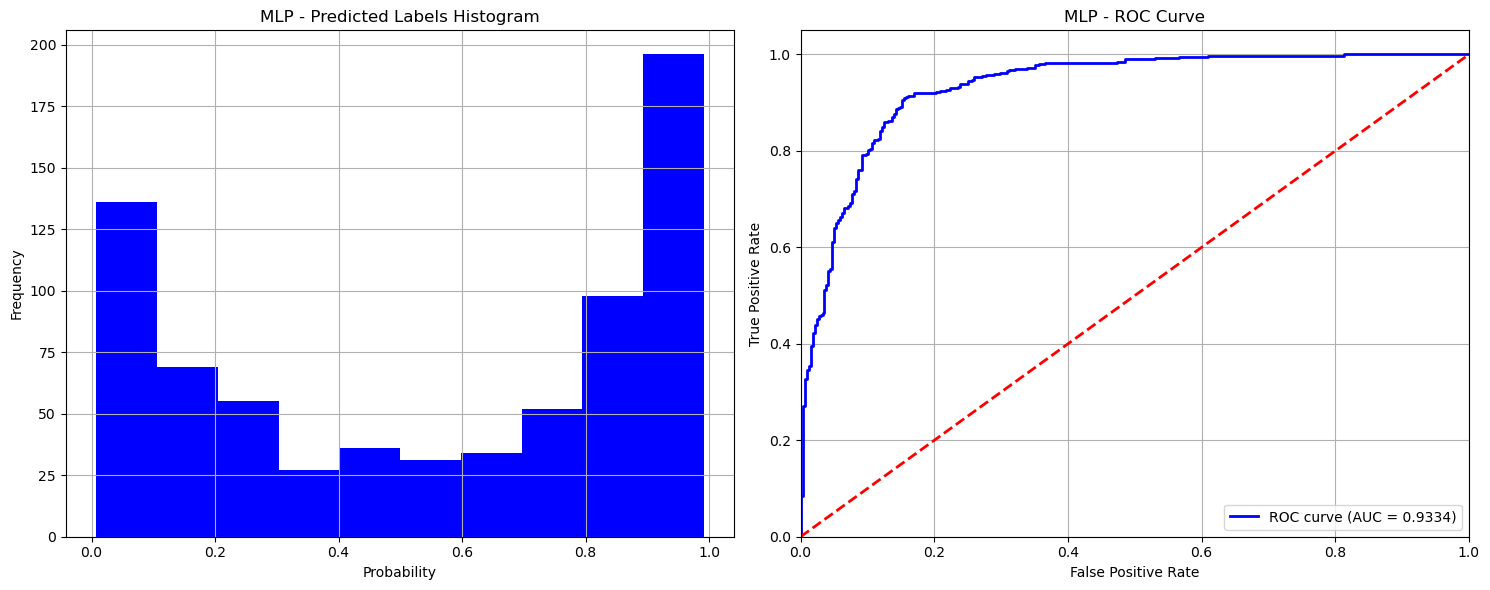

Optimal Threshold: 0.49553791143574416
F1-score: 0.8916256157635467
Balanced Accuracy: 0.8773929169657813


In [5]:
from sklearn.neural_network import MLPClassifier

# Train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(8,), activation='relu', solver='adam', max_iter=5000, random_state=42)
mlp.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_mlp = roc_auc_score(y_test, y_prob_mlp)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot predicted labels histogram
axes[0].hist(y_prob_mlp, color='b')
axes[0].set_title('MLP - Predicted Labels Histogram')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot ROC curve
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_test, y_prob_mlp)
axes[1].plot(fpr_mlp, tpr_mlp, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % auc_mlp)
axes[1].plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('MLP - ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Optimal Threshold based on ROC Curve
optimal_idx = np.argmax(tpr_mlp - fpr_mlp)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Threshold:',optimal_threshold)

y_pred_optimal = (y_prob_mlp >= optimal_threshold).astype(int)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

print("F1-score:", f1)
print("Balanced Accuracy:", balanced_accuracy)

In [6]:
# SHAP values of 2 positive and 2 negative cases

positive_indexes = np.where(y_pred_optimal == 1)[0]
negative_indexes = np.where(y_pred_optimal == 0)[0]
positive_samples_indexes = positive_indexes[:2]
negative_samples_indexes = negative_indexes[:2]

# Model prediction function
def model_predict(input_data):
    y_prob_mlp = mlp.predict_proba(input_data)[:, 1]
    return y_prob_mlp

explainer = shap.Explainer(model_predict,X_train)
shap_values = explainer(X_test)

#print(shap_values.shape) # (734, 15)

Permutation explainer: 735it [00:21, 19.83it/s]                                                                        


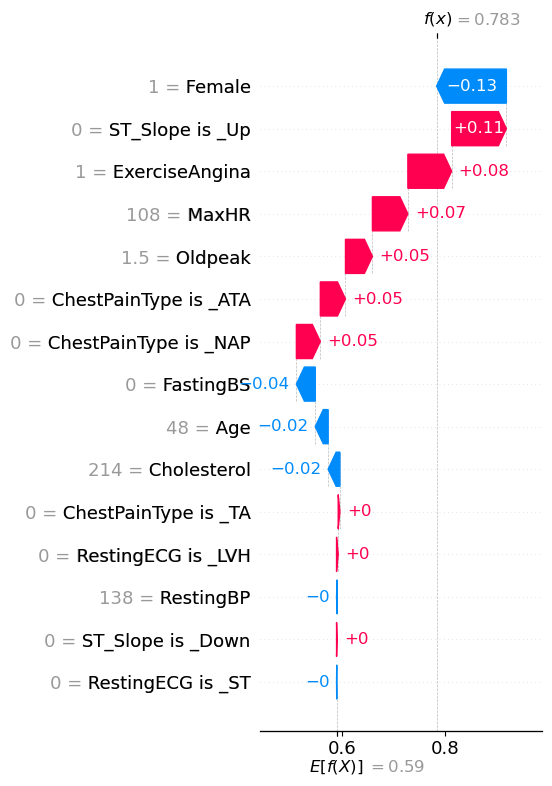

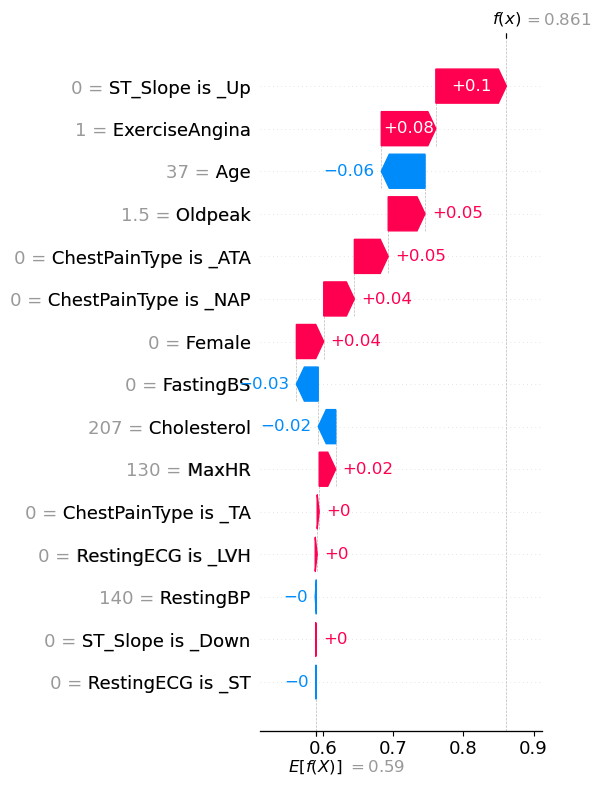

<Figure size 640x480 with 0 Axes>

In [16]:
# Positive Samples
plt.figure()
plt.subplot(1,2,1)
shap.plots.waterfall(shap_values[positive_samples_indexes[0]], max_display=15)
plt.subplot(1,2,2)
shap.plots.waterfall(shap_values[positive_samples_indexes[1]], max_display=15)
plt.tight_layout()
plt.show()

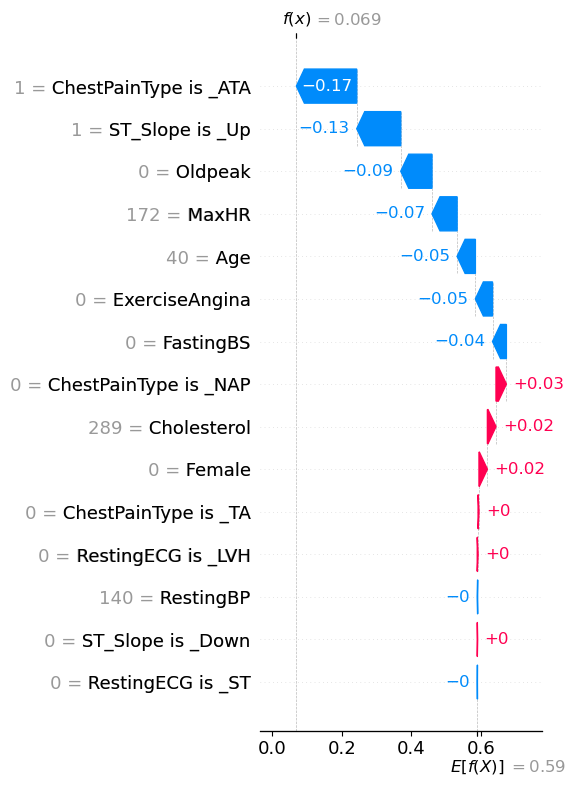

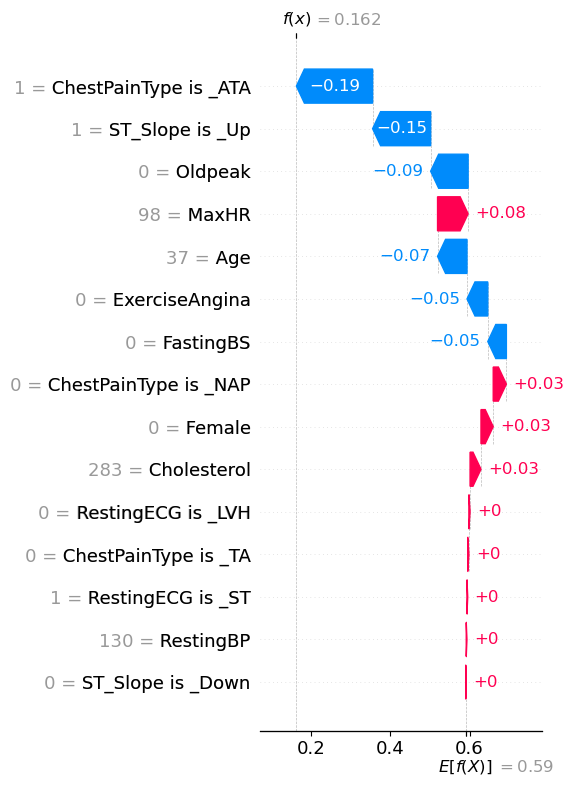

<Figure size 640x480 with 0 Axes>

In [17]:
# Negative Samples
plt.figure()
plt.subplot(1,2,1)
shap.plots.waterfall(shap_values[negative_samples_indexes[0]], max_display=15)
plt.subplot(1,2,2)
shap.plots.waterfall(shap_values[negative_samples_indexes[1]], max_display=15)
plt.tight_layout()
plt.show()

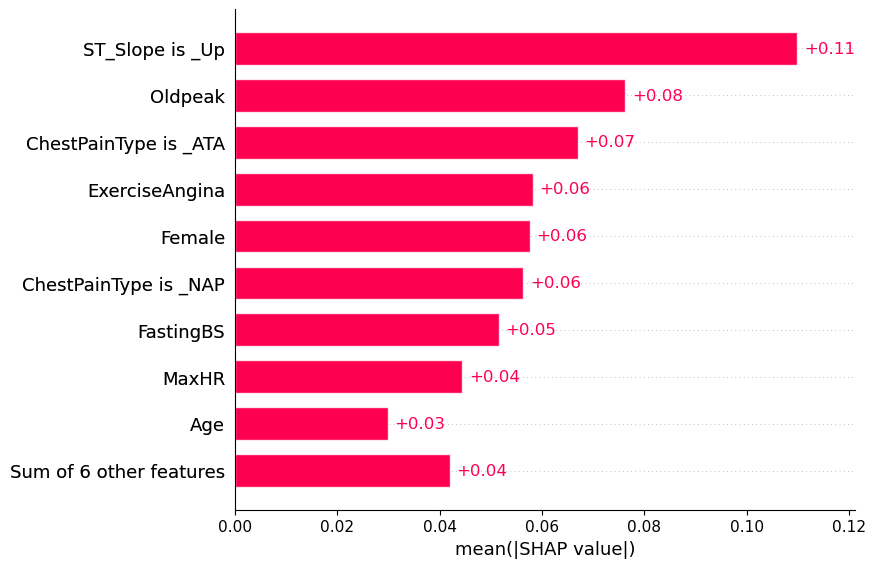

<Figure size 640x480 with 0 Axes>

In [20]:
#Mean SHAP: Which features are most important. For each feature, it calculates the mean SHAP value across all observations.
plt.figure(figsize=(15, 6))
shap.plots.bar(shap_values)
plt.tight_layout()
plt.show()